In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


**ALEXNET**

In [12]:


class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),  # Adjusted kernel size and stride for smaller input
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Adjusted kernel size and stride
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Calculate the flattened input size dynamically
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(self._get_flattened_size(), 4096),  # Dynamically calculate input size
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def _get_flattened_size(self):
        """Calculate the flattened size of the features output."""
        # Use a dummy input to get the output size of the features
        dummy_input = torch.randn(1, 1, 32, 32)
        output = self.features(dummy_input)
        return output.view(-1).size(0)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [13]:
# Define the transform for MNIST (grayscale)
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to match AlexNet expected input size
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with mean and std for MNIST
])



MNIST

Epoch [1/20], Loss: 0.2531
Test Accuracy of the model on the 10000 test images: 97.91%
Epoch [2/20], Loss: 0.0761
Test Accuracy of the model on the 10000 test images: 98.69%
Epoch [3/20], Loss: 0.0644
Test Accuracy of the model on the 10000 test images: 98.33%
Epoch [4/20], Loss: 0.0567
Test Accuracy of the model on the 10000 test images: 98.60%
Epoch [5/20], Loss: 0.0444
Test Accuracy of the model on the 10000 test images: 99.06%
Epoch [6/20], Loss: 0.0451
Test Accuracy of the model on the 10000 test images: 98.56%
Epoch [7/20], Loss: 0.0390
Test Accuracy of the model on the 10000 test images: 99.25%
Epoch [8/20], Loss: 0.0341
Test Accuracy of the model on the 10000 test images: 99.19%
Epoch [9/20], Loss: 0.0316
Test Accuracy of the model on the 10000 test images: 99.15%
Epoch [10/20], Loss: 0.0287
Test Accuracy of the model on the 10000 test images: 99.40%
Epoch [11/20], Loss: 0.0310
Test Accuracy of the model on the 10000 test images: 99.21%
Epoch [12/20], Loss: 0.0258
Test Accuracy

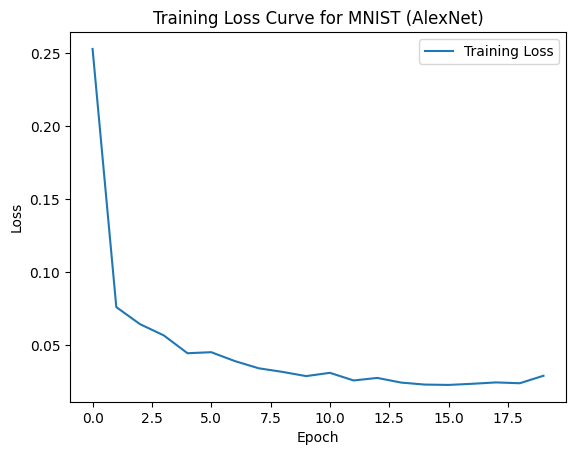

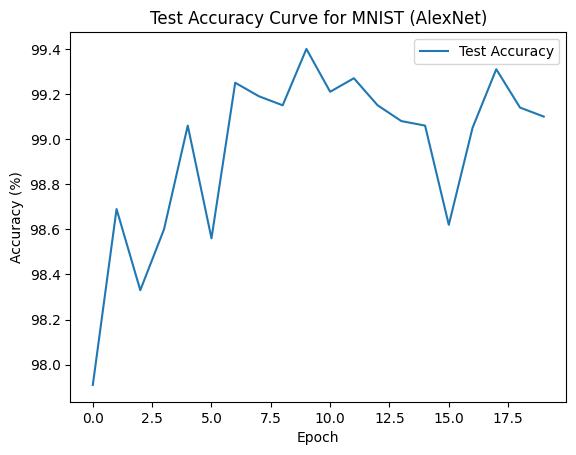

In [14]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Model, Loss Function, Optimizer
model = AlexNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


# Training and Evaluation
num_epochs = 20
train_loss_list = []
test_accuracy_list = []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_loss_list.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')



    # Testing
    model.eval()
    correct = 0
    total = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    test_accuracy_list.append(accuracy)
    print(f'Test Accuracy of the model on the 10000 test images: {accuracy:.2f}%')


# Final Metrics Calculation
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print Final Metrics
print("\nFinal Metrics for MNIST using AlexNet:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot Training Loss Curve
plt.figure()
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve for MNIST (AlexNet)')
plt.legend()
plt.show()

# Plot Test Accuracy Curve
plt.figure()
plt.plot(test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve for MNIST (AlexNet)')
plt.legend()
plt.show()

FMNIST

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.6MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 212kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.87MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.56MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch [1/20], Loss: 0.6389
Test Accuracy of the model on the 10000 test images: 85.71%
Epoch [2/20], Loss: 0.3883
Test Accuracy of the model on the 10000 test images: 87.07%
Epoch [3/20], Loss: 0.3468
Test Accuracy of the model on the 10000 test images: 87.46%
Epoch [4/20], Loss: 0.3278
Test Accuracy of the model on the 10000 test images: 88.86%
Epoch [5/20], Loss: 0.3046
Test Accuracy of the model on the 10000 test images: 88.23%
Epoch [6/20], Loss: 0.2930
Test Accuracy of the model on the 10000 test images: 88.60%
Epoch [7/20], Loss: 0.2827
Test Accuracy of the model on the 10000 test images: 89.41%
Epoch [8/20], Loss: 0.2722
Test Accuracy of the model on the 10000 test images: 90.03%
Epoch [9/20], Loss: 0.2633
Test Accuracy of the model on the 10000 test images: 89.73%
Epoch [10/20], Loss: 0.2570
Test Accuracy of the model on the 10000 test images: 90.79%
Epoch [11/20], Loss: 0.2499
Test Accurac

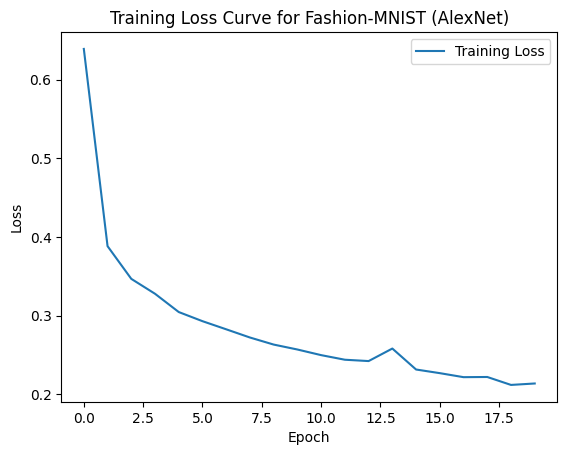

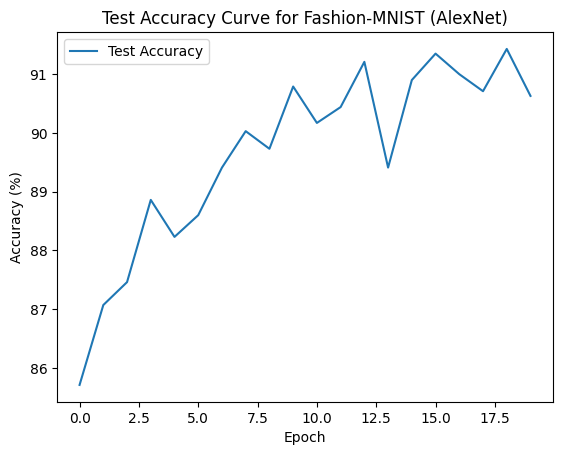

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Model, Loss Function, Optimizer
model = AlexNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


# Training and Evaluation
num_epochs = 20
train_loss_list = []
test_accuracy_list = []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_loss_list.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')



    # Testing
    model.eval()
    correct = 0
    total = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    test_accuracy_list.append(accuracy)
    print(f'Test Accuracy of the model on the 10000 test images: {accuracy:.2f}%')

# Final Metrics Calculation
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print Final Metrics
print("\nFinal Metrics for Fashion-MNIST using AlexNet:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot Training Loss Curve
plt.figure()
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve for Fashion-MNIST (AlexNet)')
plt.legend()
plt.show()

# Plot Test Accuracy Curve
plt.figure()
plt.plot(test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve for Fashion-MNIST (AlexNet)')
plt.legend()
plt.show()

CIFAR-10

100%|██████████| 170M/170M [00:05<00:00, 29.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/20], Loss: 1.7457
Test Accuracy of the model on the 10000 test images: 46.67%
Epoch [2/20], Loss: 1.3772
Test Accuracy of the model on the 10000 test images: 55.29%
Epoch [3/20], Loss: 1.1812
Test Accuracy of the model on the 10000 test images: 62.03%
Epoch [4/20], Loss: 1.0678
Test Accuracy of the model on the 10000 test images: 65.10%
Epoch [5/20], Loss: 0.9786
Test Accuracy of the model on the 10000 test images: 66.92%
Epoch [6/20], Loss: 0.9027
Test Accuracy of the model on the 10000 test images: 69.10%
Epoch [7/20], Loss: 0.8580
Test Accuracy of the model on the 10000 test images: 71.43%
Epoch [8/20], Loss: 0.8139
Test Accuracy of the model on the 10000 test images: 73.95%
Epoch [9/20], Loss: 0.7783
Test Accuracy of the model on the 10000 test images: 73.72%
Epoch [10/20], Loss: 0.7514
Test Accuracy of the model on the 10000 test images: 75.52%
Epoch [11/20], Loss: 0.7283
Test Accurac

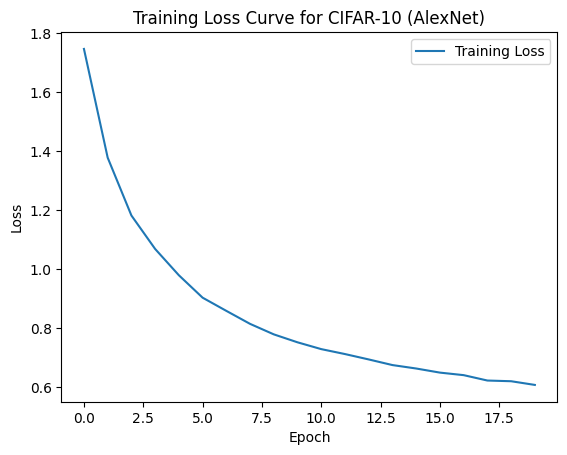

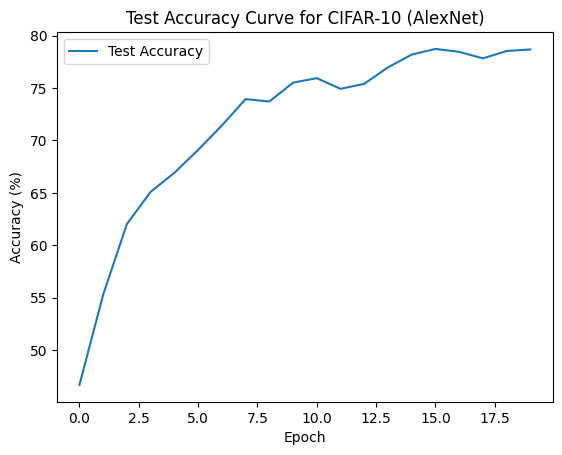

In [3]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Input: 32x32x3 -> Output: 32x32x64
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 16x16x64
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),  # Output: 16x16x192
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 8x8x192
            nn.Conv2d(192, 384, kernel_size=3, padding=1),  # Output: 8x8x384
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # Output: 8x8x256
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # Output: 8x8x256
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 4x4x256
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),  # Adjusted for 4x4x256 input
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten the tensor for the fully connected layers
        x = self.classifier(x)
        return x

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB images
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Model, Loss Function, Optimizer
model = AlexNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Training and Evaluation
num_epochs = 20
train_loss_list = []
test_accuracy_list = []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_loss_list.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')



    # Testing
    model.eval()
    correct = 0
    total = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    test_accuracy_list.append(accuracy)
    print(f'Test Accuracy of the model on the 10000 test images: {accuracy:.2f}%')

# Final Metrics Calculation
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print Final Metrics
print("\nFinal Metrics for CIFAR-10 using AlexNet:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot Training Loss Curve
plt.figure()
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve for CIFAR-10 (AlexNet)')
plt.legend()
plt.show()

# Plot Test Accuracy Curve
plt.figure()
plt.plot(test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve for CIFAR-10 (AlexNet)')
plt.legend()
plt.show()
